In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
def relu(x):
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = np.where(x > 0, 1, 0)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def sigmoid(x):
    assert isinstance(x, np.ndarray), "Input to sigmoid must be a numpy array"
    x = np.clip(x, -500, 500)
    result = 1 / (1 + np.exp(-x))
    assert np.all((result >= 0) & (result <= 1)), "Sigmoid output must be in [0,1]"
    return result

def sigmoid_derivative(x):
    assert isinstance(x, np.ndarray), "Input to sigmoid derivative must be a numpy array"
    s = sigmoid(x)
    result = s * (1 - s)
    assert np.all((result >= 0) & (result <= 0.25)), "Sigmoid derivative must be in [0,0.25]"
    return result

In [3]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, optimizer='sgd'):
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate if optimizer == 'sgd' else 0.001
        self.optimizer = optimizer
        self.weights = []
        self.biases = []
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i + 1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i + 1]), f"Weight matrix {i+1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i + 1]), f"Bias vector {i+1} has incorrect shape"
            self.weights.append(w)
            self.biases.append(b)
        if optimizer == 'adam':
            self.m_w = [np.zeros_like(w) for w in self.weights]
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.m_b = [np.zeros_like(b) for b in self.biases]
            self.v_b = [np.zeros_like(b) for b in self.biases]
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.epsilon = 1e-8
            self.t = 0

    def forward(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights) - 1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i + 1]), f"Z^{[i+1]} has incorrect shape"
            self.z_values.append(z)
            a = relu(z)
            self.activations.append(a)
        z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output z has incorrect shape"
        self.z_values.append(z)
        output = sigmoid(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.activations.append(output)
        return output

    def compute_loss(self, y_true, y_pred, l2_lambda=0.01):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have same shape"
        assert np.all((y_true == 0) | (y_true == 1)), "y_true must contain only 0s and 1s"
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        cross_entropy = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        l2_term = (l2_lambda / (2 * m)) * sum(np.sum(w ** 2) for w in self.weights)
        loss = cross_entropy + l2_term
        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss

    def compute_accuracy(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have same shape"
        predictions = (y_pred >= 0.5).astype(int)
        accuracy = np.mean(predictions == y_true)
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs, l2_lambda=0.01):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have same shape"
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        dZ = outputs - y
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (np.dot(self.activations[-2].T, dZ) + l2_lambda * self.weights[-1]) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights) - 2, -1, -1):
            dZ = np.dot(dZ, self.weights[i + 1].T) * relu_derivative(self.z_values[i])
            self.d_weights[i] = (np.dot(self.activations[i].T, dZ) + l2_lambda * self.weights[i]) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
        if self.optimizer == 'sgd':
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * self.d_weights[i]
                self.biases[i] -= self.learning_rate * self.d_biases[i]
        elif self.optimizer == 'adam':
            self.t += 1
            for i in range(len(self.weights)):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * self.d_weights[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (self.d_weights[i] ** 2)
                m_hat_w = self.m_w[i] / (1 - self.beta1 ** self.t)
                v_hat_w = self.v_w[i] / (1 - self.beta2 ** self.t)
                self.weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * self.d_biases[i]
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (self.d_biases[i] ** 2)
                m_hat_b = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_hat_b = self.v_b[i] / (1 - self.beta2 ** self.t)
                self.biases[i] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

    def train(self, X, y, X_val, y_val, epochs, batch_size, l2_lambda=0.01):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        m = X.shape[0]
        for epoch in range(epochs):
            indices = np.random.permutation(m)
            epoch_loss = 0
            for i in range(0, m, batch_size):
                batch_indices = indices[i:min(i + batch_size, m)]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs, l2_lambda)
                self.backward(X_batch, y_batch, outputs, l2_lambda)
            train_loss = epoch_loss / (m // batch_size)
            val_outputs = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_outputs, l2_lambda)
            train_acc = self.compute_accuracy(y, self.forward(X))
            val_acc = self.compute_accuracy(y_val, val_outputs)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        outputs = self.forward(X)
        return (outputs >= 0.5).astype(int)

In [4]:
def load_and_preprocess_data():
    file_path = 'diabetes.csv'
    columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
               'DiabetesPedigreeFunction', 'Age', 'Outcome']
    try:
        data = pd.read_csv(file_path, names=columns, header=0)
        for col in columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')
        if data.isnull().any().any():
            print("Warning: NaN values detected after numeric conversion. Filling with median.")
            data = data.fillna(data.median())
        for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
            median_non_zero = data.loc[data[col] != 0, col].median()
            data.loc[data[col] == 0, col] = median_non_zero
        X = data.drop('Outcome', axis=1).values
        y = data['Outcome'].values.reshape(-1, 1)
        X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
        X_train_full, X_test, y_train_full, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
        )
        print("Class distribution (diabetic ratio):")
        print(f"Full dataset: {np.mean(y):.3f}")
        print(f"Train set: {np.mean(y_train):.3f}")
        print(f"Validation set: {np.mean(y_val):.3f}")
        print(f"Test set: {np.mean(y_test):.3f}")
        return X_train, X_val, X_test, y_train, y_val, y_test, data
    except Exception as e:
        raise ValueError(f"Failed to load or process data: {e}")

In [9]:
def plot_feature_distributions(data):
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(data.columns[:-1]):
        plt.subplot(2, 4, i + 1)
        sns.histplot(data[col], kde=True)
        plt.title(f'{col}')
        plt.xlabel('')
    plt.tight_layout()
    plt.savefig('feature_distributions.png')
    plt.show()

In [10]:
def plot_class_distribution(data):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=data['Outcome'])
    plt.title('Class Distribution')
    plt.xlabel('Outcome (0: Non-Diabetic, 1: Diabetic)')
    plt.ylabel('Count')
    plt.savefig('class_distribution.png')
    plt.show()

In [11]:
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, title_prefix):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title(f'{title_prefix} Loss vs. Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title(f'{title_prefix} Accuracy vs. Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.savefig(f'{title_prefix.lower().replace(" ", "_")}_curves.png')
    plt.show()

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test, data = load_and_preprocess_data()
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Class distribution (diabetic ratio):
Full dataset: 0.349
Train set: 0.348
Validation set: 0.350
Test set: 0.351
Training data shape: (491, 8)
Validation data shape: (123, 8)
Test data shape: (154, 8)


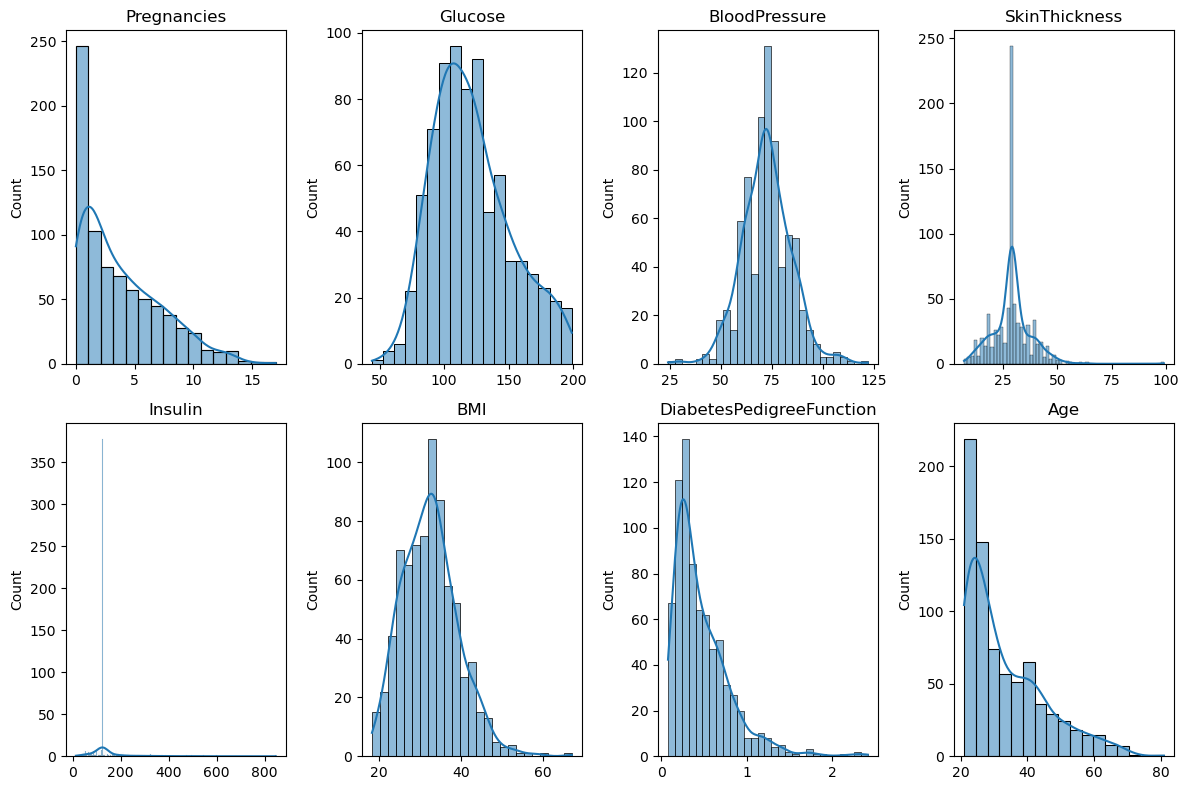

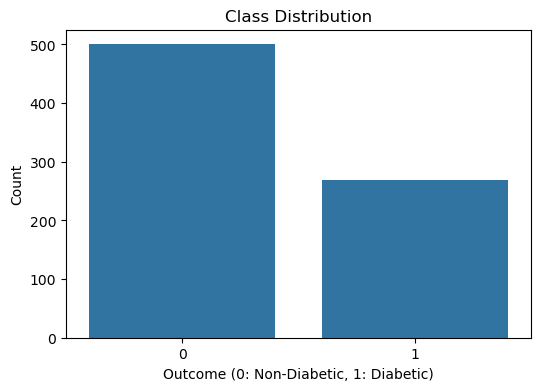

In [13]:
plot_feature_distributions(data)
plot_class_distribution(data)

In [14]:
def run_cross_validation(X, y, layer_sizes, epochs=100, batch_size=32, l2_lambda=0.01, optimizer='sgd'):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_accuracies = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_v = X[train_idx], X[val_idx]
        y_tr, y_v = y[train_idx], y[val_idx]
        nn = NeuralNetwork(layer_sizes=layer_sizes, learning_rate=0.01, optimizer=optimizer)
        _, _, _, val_accs = nn.train(X_tr, y_tr, X_v, y_v, epochs, batch_size, l2_lambda)
        val_accuracies.append(val_accs[-1])
        print(f"Fold {fold+1}, Final Val Accuracy: {val_accs[-1]:.4f}")
    return val_accuracies


Cross-Validation for Baseline Architecture (SGD)
Epoch 0, Train Loss: 0.8658, Val Loss: 0.7116, Train Acc: 0.5621, Val Acc: 0.5935
Epoch 10, Train Loss: 0.6415, Val Loss: 0.5809, Train Acc: 0.6945, Val Acc: 0.7073
Epoch 20, Train Loss: 0.5628, Val Loss: 0.5403, Train Acc: 0.7434, Val Acc: 0.7236
Epoch 30, Train Loss: 0.5238, Val Loss: 0.5255, Train Acc: 0.7658, Val Acc: 0.7398
Epoch 40, Train Loss: 0.5101, Val Loss: 0.5261, Train Acc: 0.7760, Val Acc: 0.7398
Epoch 50, Train Loss: 0.4989, Val Loss: 0.5275, Train Acc: 0.7760, Val Acc: 0.7236
Epoch 60, Train Loss: 0.4897, Val Loss: 0.5300, Train Acc: 0.7821, Val Acc: 0.7398
Epoch 70, Train Loss: 0.4763, Val Loss: 0.5342, Train Acc: 0.7902, Val Acc: 0.7236
Epoch 80, Train Loss: 0.4711, Val Loss: 0.5335, Train Acc: 0.7943, Val Acc: 0.7236
Epoch 90, Train Loss: 0.4626, Val Loss: 0.5353, Train Acc: 0.7984, Val Acc: 0.7236
Fold 1, Final Val Accuracy: 0.7317
Epoch 0, Train Loss: 0.8333, Val Loss: 0.7961, Train Acc: 0.5764, Val Acc: 0.5528
Epoc

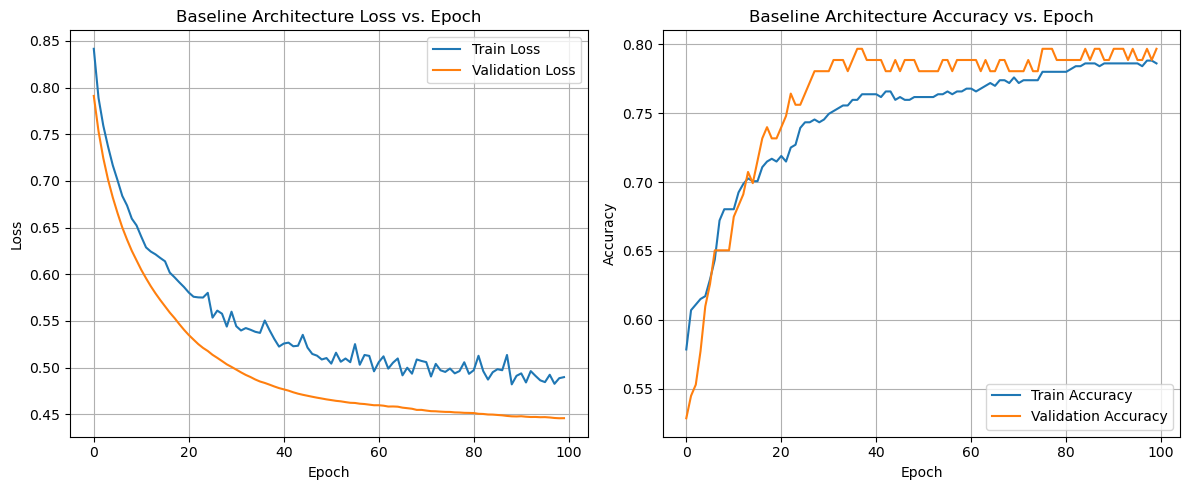


Classification Report for Baseline Architecture (SGD):
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       100
           1       0.58      0.52      0.55        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154



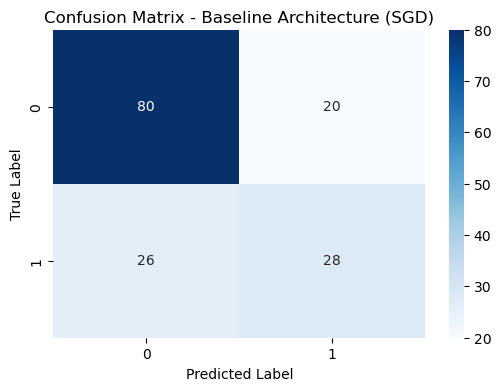


Training Baseline Architecture with Adam for Comparison
Epoch 0, Train Loss: 0.8301, Val Loss: 0.7679, Train Acc: 0.6110, Val Acc: 0.5447
Epoch 10, Train Loss: 0.5489, Val Loss: 0.5112, Train Acc: 0.7597, Val Acc: 0.7805
Epoch 20, Train Loss: 0.5018, Val Loss: 0.4630, Train Acc: 0.7821, Val Acc: 0.7886
Epoch 30, Train Loss: 0.4818, Val Loss: 0.4496, Train Acc: 0.7984, Val Acc: 0.7967
Epoch 40, Train Loss: 0.4664, Val Loss: 0.4402, Train Acc: 0.7963, Val Acc: 0.7967
Epoch 50, Train Loss: 0.4481, Val Loss: 0.4391, Train Acc: 0.8147, Val Acc: 0.8130
Epoch 60, Train Loss: 0.4538, Val Loss: 0.4369, Train Acc: 0.8208, Val Acc: 0.8049
Epoch 70, Train Loss: 0.4485, Val Loss: 0.4330, Train Acc: 0.8228, Val Acc: 0.8130
Epoch 80, Train Loss: 0.4391, Val Loss: 0.4299, Train Acc: 0.8248, Val Acc: 0.8130
Epoch 90, Train Loss: 0.4278, Val Loss: 0.4280, Train Acc: 0.8248, Val Acc: 0.8211
Epoch 100, Train Loss: 0.4291, Val Loss: 0.4277, Train Acc: 0.8269, Val Acc: 0.8130
Epoch 110, Train Loss: 0.4240,

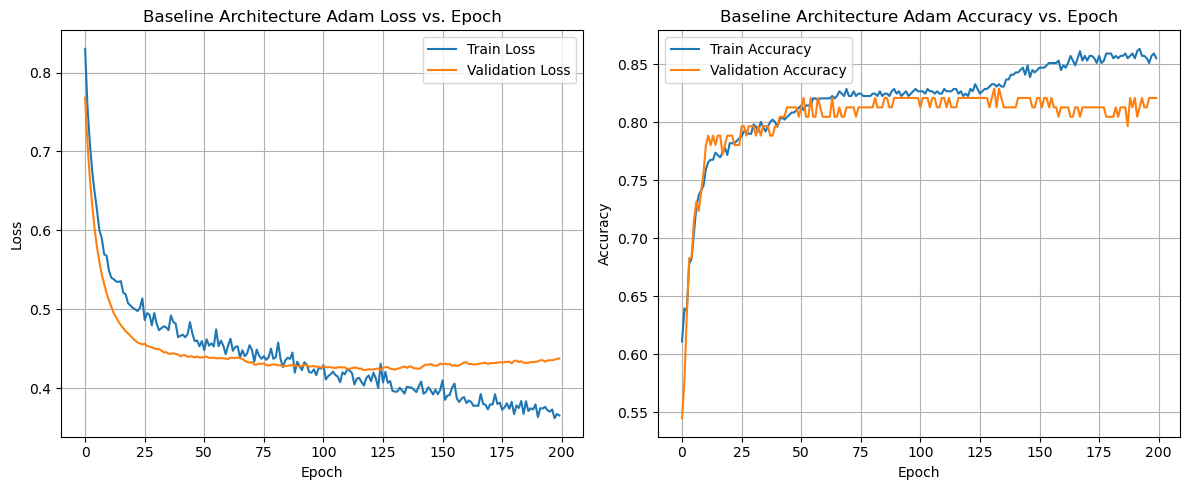


Classification Report for Baseline Architecture (Adam):
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.62      0.61      0.62        54

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154



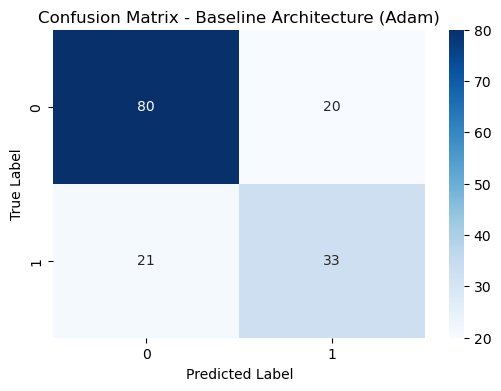


Cross-Validation for Deeper Architecture (SGD)
Epoch 0, Train Loss: 0.6865, Val Loss: 0.6394, Train Acc: 0.6477, Val Acc: 0.6260
Epoch 10, Train Loss: 0.5889, Val Loss: 0.5730, Train Acc: 0.6986, Val Acc: 0.6423
Epoch 20, Train Loss: 0.5409, Val Loss: 0.5489, Train Acc: 0.7536, Val Acc: 0.6992
Epoch 30, Train Loss: 0.5213, Val Loss: 0.5420, Train Acc: 0.7597, Val Acc: 0.6911
Epoch 40, Train Loss: 0.5020, Val Loss: 0.5393, Train Acc: 0.7760, Val Acc: 0.6992
Epoch 50, Train Loss: 0.4914, Val Loss: 0.5384, Train Acc: 0.7841, Val Acc: 0.7073
Epoch 60, Train Loss: 0.4875, Val Loss: 0.5412, Train Acc: 0.7862, Val Acc: 0.7154
Epoch 70, Train Loss: 0.4773, Val Loss: 0.5399, Train Acc: 0.7963, Val Acc: 0.7154
Epoch 80, Train Loss: 0.4648, Val Loss: 0.5349, Train Acc: 0.8004, Val Acc: 0.7154
Epoch 90, Train Loss: 0.4629, Val Loss: 0.5327, Train Acc: 0.8065, Val Acc: 0.7236
Fold 1, Final Val Accuracy: 0.7236
Epoch 0, Train Loss: 0.6863, Val Loss: 0.6335, Train Acc: 0.6538, Val Acc: 0.6260
Epoch 

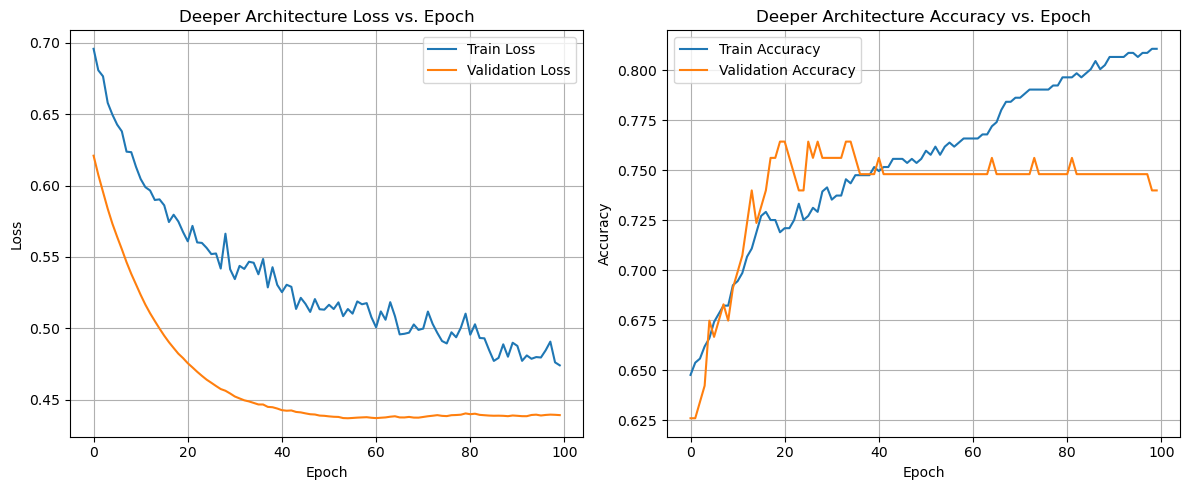


Classification Report for Deeper Architecture (SGD):
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       100
           1       0.60      0.54      0.57        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.68       154
weighted avg       0.71      0.71      0.71       154



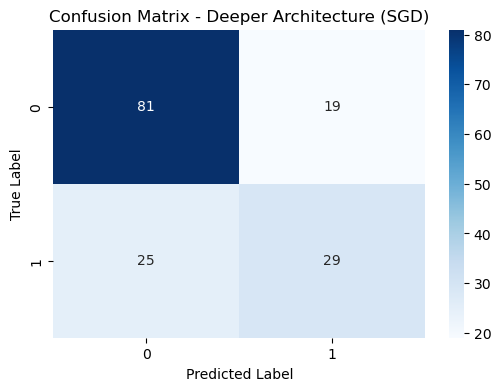


Training Deeper Architecture with Adam for Comparison
Epoch 0, Train Loss: 0.6823, Val Loss: 0.5875, Train Acc: 0.6701, Val Acc: 0.6585
Epoch 10, Train Loss: 0.5032, Val Loss: 0.4320, Train Acc: 0.7739, Val Acc: 0.7398
Epoch 20, Train Loss: 0.4554, Val Loss: 0.4437, Train Acc: 0.8106, Val Acc: 0.7561
Epoch 30, Train Loss: 0.4253, Val Loss: 0.4632, Train Acc: 0.8432, Val Acc: 0.7642
Epoch 40, Train Loss: 0.4052, Val Loss: 0.4734, Train Acc: 0.8534, Val Acc: 0.7724
Epoch 50, Train Loss: 0.3829, Val Loss: 0.4833, Train Acc: 0.8697, Val Acc: 0.7724
Epoch 60, Train Loss: 0.3501, Val Loss: 0.4974, Train Acc: 0.8798, Val Acc: 0.7805
Epoch 70, Train Loss: 0.3260, Val Loss: 0.5187, Train Acc: 0.8819, Val Acc: 0.7805
Epoch 80, Train Loss: 0.3099, Val Loss: 0.5358, Train Acc: 0.8961, Val Acc: 0.7805
Epoch 90, Train Loss: 0.2816, Val Loss: 0.5694, Train Acc: 0.9063, Val Acc: 0.7724
Epoch 100, Train Loss: 0.2554, Val Loss: 0.5959, Train Acc: 0.9145, Val Acc: 0.7642
Epoch 110, Train Loss: 0.2328, V

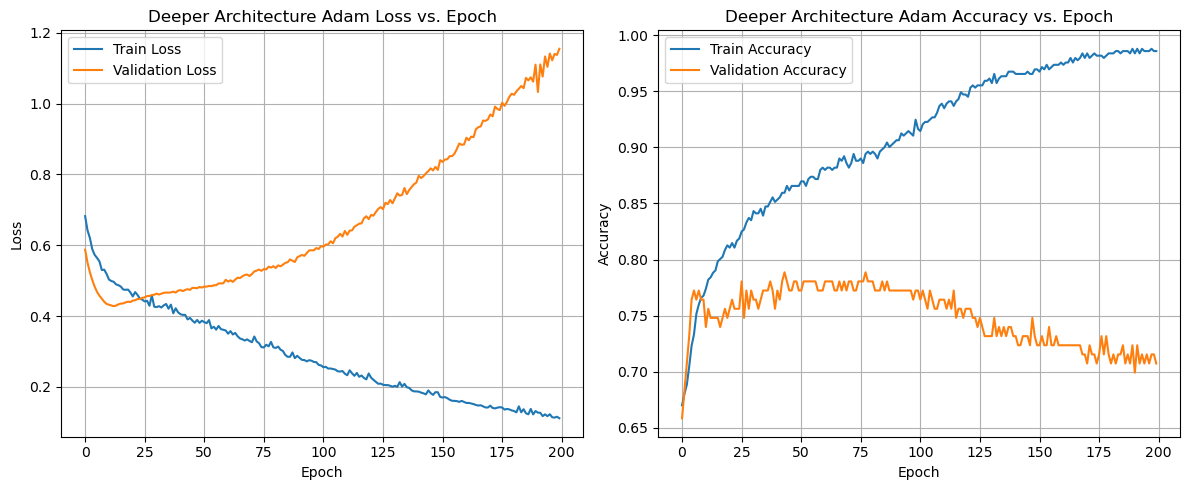


Classification Report for Deeper Architecture (Adam):
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       100
           1       0.65      0.57      0.61        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.71       154
weighted avg       0.73      0.74      0.74       154



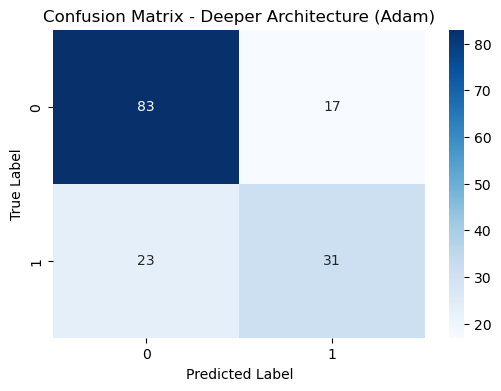

In [17]:
architectures = [
    ([X_train.shape[1], 16, 8, 1], "Baseline Architecture"),
    ([X_train.shape[1], 32, 16, 8, 1], "Deeper Architecture")
]

results = []
cv_results = {}
for layer_sizes, name in architectures:
    print(f"\nCross-Validation for {name} (SGD)")
    val_accuracies = run_cross_validation(
        np.vstack((X_train, X_val)), np.vstack((y_train, y_val)),
        layer_sizes, epochs=100, batch_size=32, l2_lambda=0.01, optimizer='sgd'
    )
    cv_results[f"{name} (SGD)"] = (np.mean(val_accuracies), np.std(val_accuracies))
    print(f"{name} CV Accuracy: {np.mean(val_accuracies):.4f} ± {np.std(val_accuracies):.4f}")
    
    print(f"\nTraining {name} on Full Training Set (SGD)")
    nn = NeuralNetwork(layer_sizes=layer_sizes, learning_rate=0.01, optimizer='sgd')
    train_losses, val_losses, train_accs, val_accs = nn.train(
        X_train, y_train, X_val, y_val, epochs=100, batch_size=32, l2_lambda=0.01
    )
    y_pred = nn.predict(X_test)
    results.append((name, y_pred, train_losses, val_losses, train_accs, val_accs))
    
    plot_results(train_losses, val_losses, train_accs, val_accs, name)
    
    print(f"\nClassification Report for {name} (SGD):")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name} (SGD)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'confusion_matrix_{name.lower().replace(" ", "_")}_sgd.png')
    plt.show()

    print(f"\nTraining {name} with Adam for Comparison")
    nn_adam = NeuralNetwork(layer_sizes=layer_sizes, learning_rate=0.001, optimizer='adam')
    train_losses_adam, val_losses_adam, train_accs_adam, val_accs_adam = nn_adam.train(
        X_train, y_train, X_val, y_val, epochs=200, batch_size=32, l2_lambda=0.01
    )
    y_pred_adam = nn_adam.predict(X_test)
    cv_results[f"{name} (Adam)"] = (val_accs_adam[-1], 0)
    plot_results(train_losses_adam, val_losses_adam, train_accs_adam, val_accs_adam, f"{name} Adam")
    print(f"\nClassification Report for {name} (Adam):")
    report_adam = classification_report(y_test, y_pred_adam, output_dict=True)
    print(classification_report(y_test, y_pred_adam))
    cm_adam = confusion_matrix(y_test, y_pred_adam)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_adam, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name} (Adam)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'cm_{name.lower().replace(" ", "_")}_adam.png')
    plt.show()